# Station Air Pollution Estimation

For each station, find a good model to predict the individual pollutants.

In [28]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Models
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
metrics = [root_mean_squared_error, r2_score, mean_absolute_error]

from utils import *

datasets_folder = './datasets'
verbosity=0
figsize = (20,4)

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Import

We will only focus on the station with the most agents, Porta San Felice.

In [ ]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [49]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(pollution_data[station], traffic_data[station], weather_data, encoding_method=date_encoding)
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of features: {n_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO, NO2, NOX, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of features: 26


## **Training Data**

In [8]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

In [ ]:
training_sets = {} # I wanted to keep train and test on separate variables
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [24]:
training_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,W_VEC_INT,LEAFW,ET0,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.062321,0.096698,0.0,0.911899,0.0,0.034247,0.579722,0.02069,0.0,0.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


## **Hourly agents**

As a test, let's see if the same agent-model achieves similar performances on all the stations.

In [ ]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, sequences:bool)
hour_results = {} # station: dict[agent: dict[metric: score]] (maybe?)

### **Models**

In [59]:
def create_sequences(x_df, time_steps=10):
    X = []
    for i in range(len(x_df) - time_steps):
        X.append(x_df.iloc[i:i+time_steps].values) # time_steps values are needed to predict the next value
    return np.array(X)

#### **Random Forest Regressor**

In [ ]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

*Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

rfr_model = RandomForestRegressor(**rfr_params)
rfr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

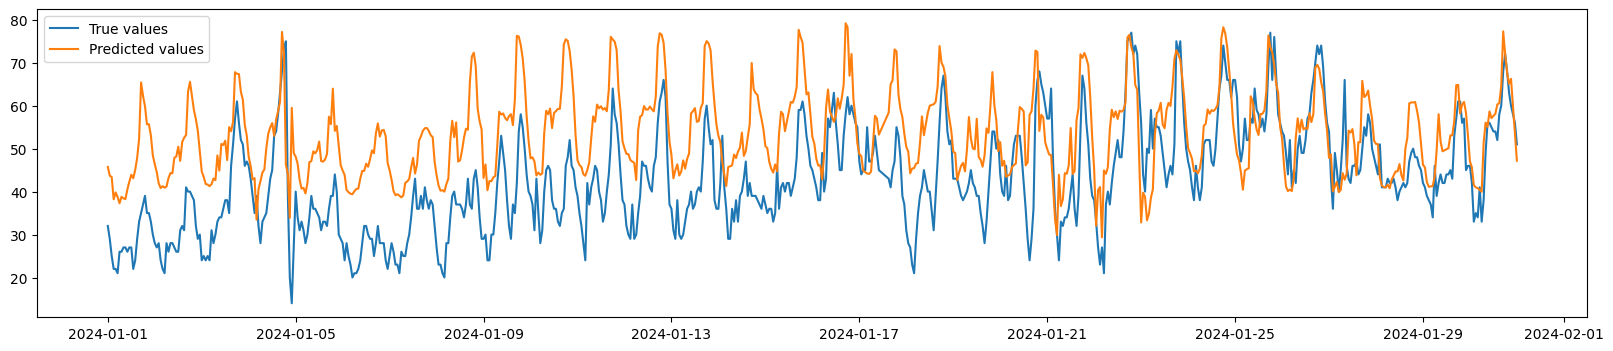

root_mean_squared_error: 18.90471593888504
r2_score: -0.7775068934726943
mean_absolute_error: 15.981852580562716


In [87]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

rfr_scores={}
for m in metrics:
    rfr_score = m(test_sets[station][agent]['y'],rfr_pred_df)
    print(f'{m.__name__}: {rfr_score}')
    rfr_scores[m.__name__] = rfr_score

#### **LSTM**

In [ ]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_params = {
    'time_steps': 5,
    'n_features': n_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

lstm_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['LSTM'] = (buid_lstm_model, lstm_params, lstm_train_params, True)

*Testing...*

In [67]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

ts = lstm_params['time_steps']
lstm_x_train = create_sequences(training_sets[station][agent]['x'], ts)
lstm_y_train = training_sets[station][agent]['y'].iloc[ts:] # for the first `time_steps` values we don't have training samples to predict them

lstm_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_x_test = create_sequences(lstm_x_test, ts)
lstm_y_test = test_sets[station][agent]['y']

In [ ]:
lstm_model = buid_lstm_model(**lstm_params)
lstm_model.fit(
    lstm_x_train,
    lstm_y_train,
    **lstm_train_params
)
lstm_pred = lstm_model.predict(lstm_x_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)


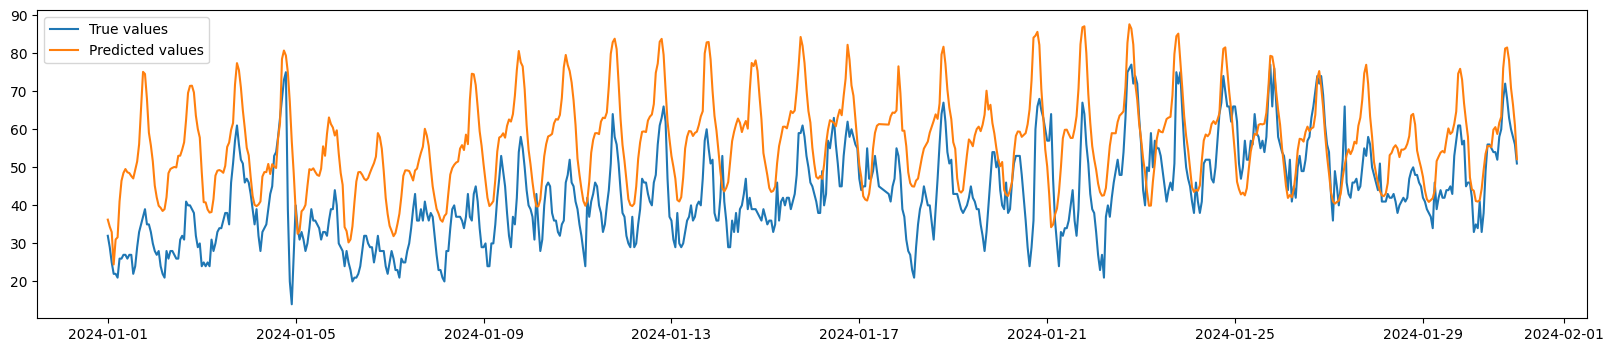

root_mean_squared_error: 20.522773696680627
r2_score: -1.094802550543807
mean_absolute_error: 17.33159978946725


In [86]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(lstm_y_test[(lstm_y_test.index>=start)&(lstm_y_test.index<=end)], label='True values')
plt.plot(lstm_pred_df[(lstm_pred_df.index>=start)&(lstm_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

lstm_scores={}
for m in metrics:
    lstm_score = m(test_sets[station][agent]['y'],lstm_pred_df)
    print(f'{m.__name__}: {lstm_score}')
    lstm_scores[m.__name__] = lstm_score

#### **Feed Forward Neural Network**

In [ ]:
def build_ffnn_model(n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_params = {
    'n_features': n_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

*Testing...*

In [77]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

ffnn_model = build_ffnn_model(**ffnn_params)
ffnn_model.fit(
    training_sets[station][agent]['x'], 
    training_sets[station][agent]['y'], 
    **ffnn_train_params
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/3
1343/1343 [==============================] - 6s 4ms/step - loss: 12.6652
Epoch 2/3
1343/1343 [==============================] - 5s 4ms/step - loss: 10.5945
Epoch 3/3
269/269 [==============================] - 0s 1ms/step


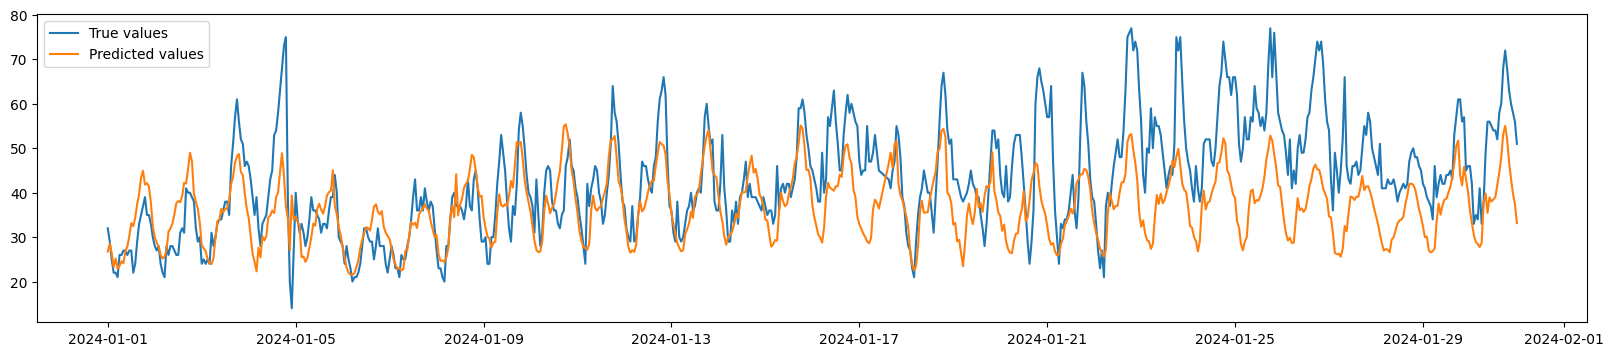

root_mean_squared_error: 12.796704203586517
r2_score: 0.18554471797341698
mean_absolute_error: 10.342419601460856


In [85]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(ffnn_pred_df[(ffnn_pred_df.index>=start)&(ffnn_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

ffnn_scores={}
for m in metrics:
    ffnn_score = m(test_sets[station][agent]['y'],ffnn_pred_df)
    print(f'{m.__name__}: {ffnn_score}')
    ffnn_scores[m.__name__] = ffnn_score

#### **XGBoost**

In [ ]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    # 'max_depth': 20
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

*Testing...*

In [82]:
agent = 'PORTA SAN FELICE'
agent = 'NO2'

xgbr_model = xgb.XGBRegressor(**xgbr_params)
xgbr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

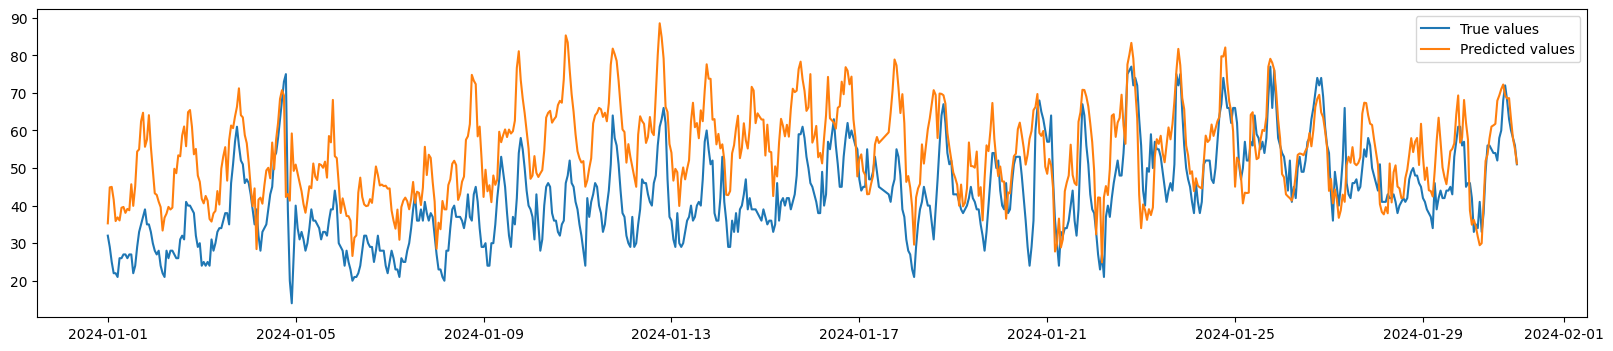

root_mean_squared_error: 19.12984719767422
r2_score: -0.820094694222993
mean_absolute_error: 15.971076815553767


In [84]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

xgbr_scores={}
for m in metrics:
    xgbr_score = m(test_sets[station][agent]['y'],xgbr_pred_df)
    print(f'{m.__name__}: {xgbr_score}')
    xgbr_scores[m.__name__] = xgbr_score

#### **Test comparisons**

Assuming that the predictions are on the same station and agent.

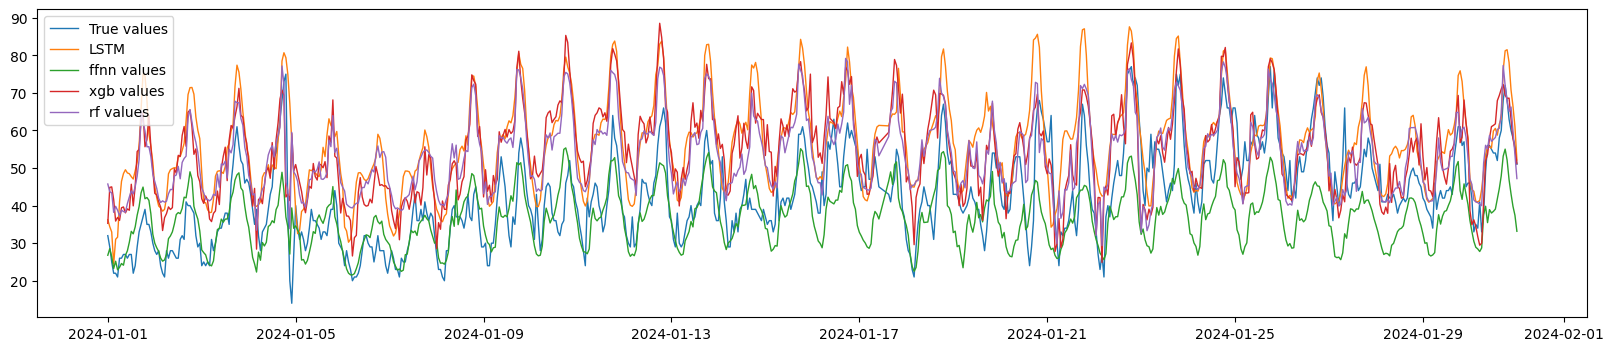

root_mean_squared_error:
 - LSTM: 20.522773696680627
 - FFNN: 12.796704203586517
 - XGB: 19.12984719767422
 - RF: 18.90471593888504
r2_score:
 - LSTM: -1.094802550543807
 - FFNN: 0.18554471797341698
 - XGB: -0.820094694222993
 - RF: -0.7775068934726943
mean_absolute_error:
 - LSTM: 17.33159978946725
 - FFNN: 10.342419601460856
 - XGB: 15.971076815553767
 - RF: 15.981852580562716


In [88]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values', linewidth=1)
plt.plot(lstm_pred_df[(lstm_pred_df.index>=start)&(lstm_pred_df.index<=end)], label='LSTM', linewidth=1)
plt.plot(ffnn_pred_df[(ffnn_pred_df.index>=start)&(ffnn_pred_df.index<=end)], label='ffnn values', linewidth=1)
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='xgb values', linewidth=1)
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='rf values', linewidth=1)
# plt.xlim(test_sets[station][agent]['y'].index[0],test_sets[station][agent]['y'].index[-1])
plt.legend()
plt.show()

for m in metrics:
    name = m.__name__
    print(f'{name}:')
    print(f' - LSTM: {lstm_scores[name]}')
    print(f' - FFNN: {ffnn_scores[name]}')
    print(f' - XGB: {xgbr_scores[name]}')
    print(f' - RF: {rfr_scores[name]}')

ziocane ffnn ha gli errori più bassi di tutti ma fa merda

#### todo

non ho aggiustato queste seguenti celle con la nuova nomenclatura

['Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT', 'W_VEC_DIR', 'W_VEC_INT', 'LEAFW', 'ET0']


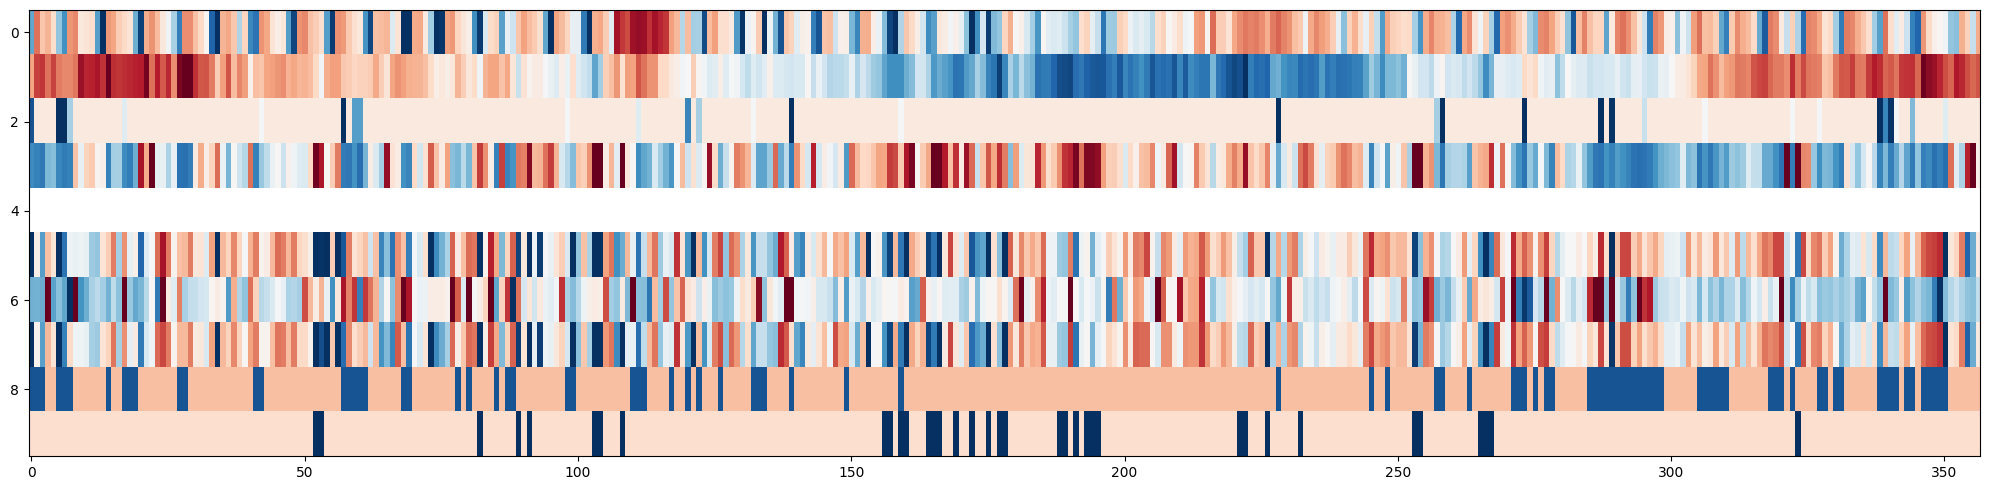

In [102]:
cols=co_x_test.columns[:10]
hpcsv = co_x_test[cols].copy()
hpcsv = (hpcsv - hpcsv.mean()) / hpcsv.std()
plot_dataframe(hpcsv[offset:samples+offset])
print([c for c in cols])

In [ ]:
co_y_pred_lstm_train = co_lstm.predict(lstm_x_train)
co_y_pred_df_lstm_train = pd.DataFrame(co_y_pred_lstm_train, index=co_y_train.index[time_steps:])

co_y_pred_ffnn_train = co_ffnn.predict(co_x_train)
co_y_pred_df_ffnn_train = pd.DataFrame(co_y_pred_ffnn_train, index=co_y_train.index) 

1343/1343 [==============================] - 2s 1ms/step


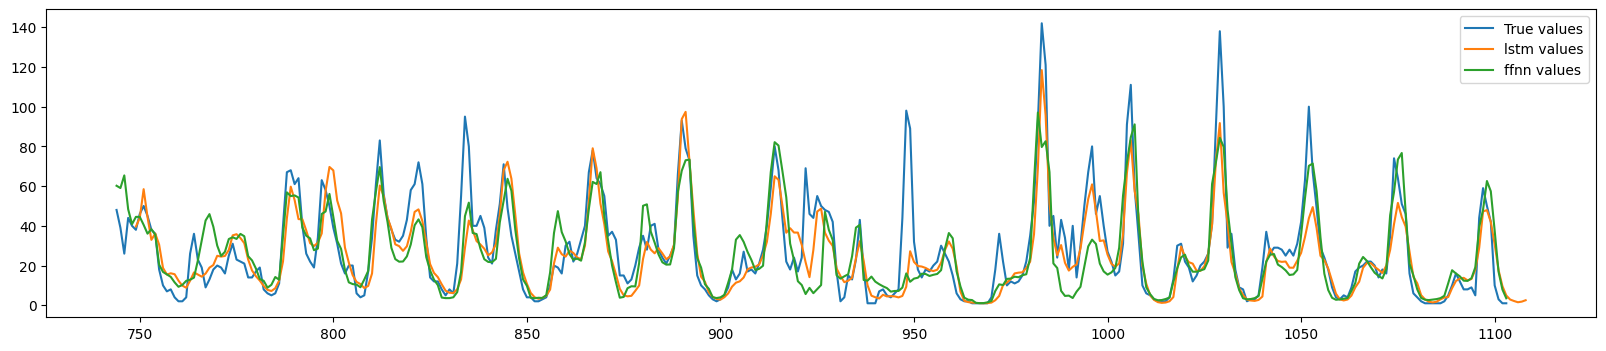

root_mean_squared_error:
 - LSTM: 12.913079940672672
 - FFNN: 15.309223833152833
r2_score:
 - LSTM: 0.6920436581439495
 - FFNN: 0.5676927049875149
mean_absolute_error:
 - LSTM: 6.428883090441418
 - FFNN: 7.685955406784184


In [78]:
samples = 24 * 15
offset = 24 * 31 * 1

plt.figure(figsize=(20,4))
plt.plot(co_y_train.iloc[offset:samples+offset], label='True values')
plt.plot(co_y_pred_df_lstm_train.iloc[offset:samples+offset], label='lstm values')
plt.plot(co_y_pred_df_ffnn_train.iloc[offset:samples+offset], label='ffnn values')
plt.legend()
plt.show()

for m in metrics:
    score_lstm = m(co_y_train.iloc[time_steps:],co_y_pred_df_lstm_train)
    score_ffnn = m(co_y_train,co_y_pred_df_ffnn_train)
    print(f'{m.__name__}:\n - LSTM: {score_lstm}\n - FFNN: {score_ffnn}')

## **Daily agents**

In [89]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, sequences:bool|dict)
daily_results = {} # station: dict[agent: dict[metric: score]] (maybe?)

### **Models**

## **Agents Evaluations**

Compute the agents with all the models and compare the results...

divide hour and day agents...

compile the `hour_results` and `daily_results` variable..


per i modelli che usano le sequenze bisogna controlalre sul dizionario i time steps e creare i set bhooo. per ora sta parte si può lasciar stare e continuare a cercare modelli/confrontare a mano. sennò se ci capisci fallo sennò lo faccio io domani

ah e si possono aggiungere metriche da provare, perchè alla fine dipendono un po dal range degli agent